In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from keras import optimizers

# Loading Datasets

In [2]:
cldt = pd.read_csv("../input/electrical-fault-detection-and-classification/classData.csv")
ddt = pd.read_csv("../input/electrical-fault-detection-and-classification/detect_dataset.csv")

# **Fault Classification**

# Visualization of classifier data

In [3]:
cldt['fault_types'] = cldt['G'].astype('str') + cldt['C'].astype('str') + cldt['B'].astype('str') + cldt['A'].astype('str')

categories = ["NF", "LG", "LL", "LLG", "LLL", "LLLG"]
encode = {"fault_types":
         {
             "0000" : 0,
             "1001" : 1,
             "0110" : 2,
             "1011" : 3,
             "0111" : 4,
             "1111" : 5
         }}

cldt.replace(encode, inplace = True)

In [4]:
cldt

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_types
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1
...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0


In [5]:
def plot_class(fault_type):
    i = categories.index(fault_type)
    print("Plot for fault type =", fault_type)
    fig = plt.figure(figsize = (10,8))
    plt1 = fig.add_subplot(211)
    plt1.plot(cldt[cldt['fault_types'] == i]["Ia"],'r', label = "Ia")
    plt1.plot(cldt[cldt['fault_types'] == i]["Ib"],'b', label = "Ib")
    plt1.plot(cldt[cldt['fault_types'] == i]["Ic"],'g', label = "Ic")
    plt1.legend()

    plt2 = fig.add_subplot(212)
    plt2.plot(cldt[cldt['fault_types'] == i]["Va"],'r', label = "Va")
    plt2.plot(cldt[cldt['fault_types'] == i]["Vb"],'b', label = "Vb")
    plt2.plot(cldt[cldt['fault_types'] == i]["Vc"],'g', label = "Vc")
    plt2.legend()
    plt.show()

Plot for fault type = NF


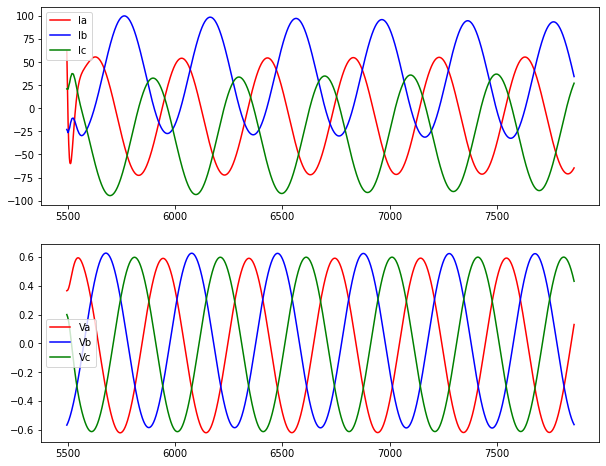

Plot for fault type = LG


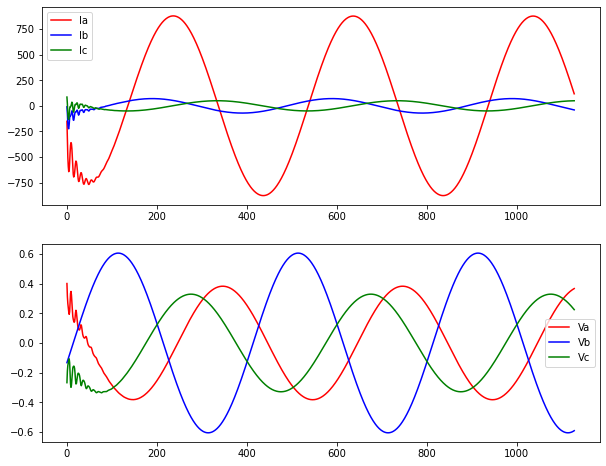

Plot for fault type = LL


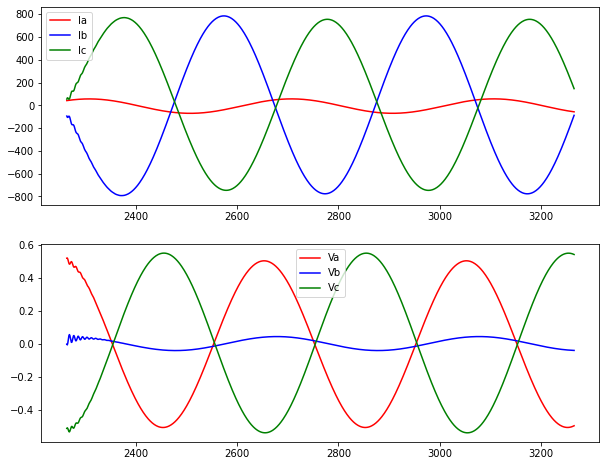

Plot for fault type = LLG


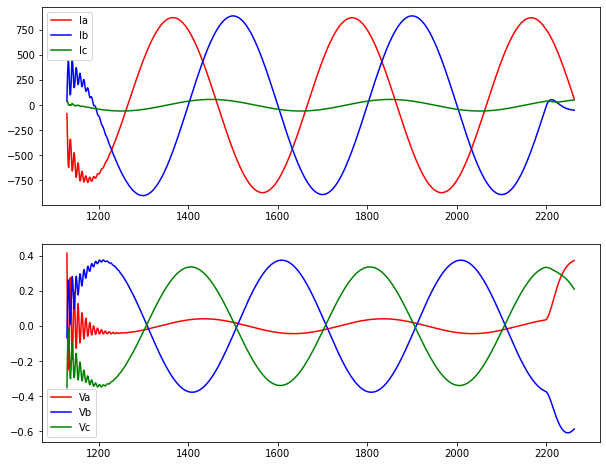

Plot for fault type = LLL


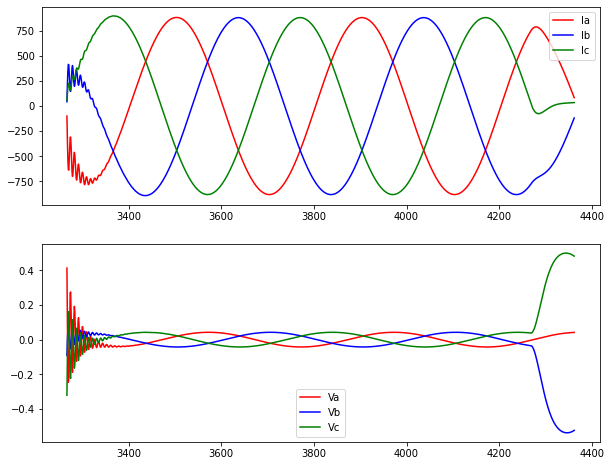

Plot for fault type = LLLG


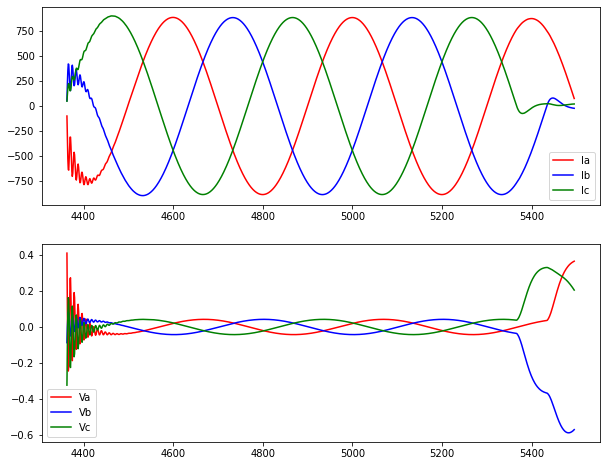

In [6]:
for x in categories:
    plot_class(x)

# Extracting Features and Labels

In [7]:
X = cldt.iloc[:, 4:-1]
X = X / X.max(axis = 0)
y = cldt.iloc[:, -1]

In [8]:
X

,Ia,Ib,Ic,Va,Vb,Vc
0,-0.170809,-0.010875,0.095199,0.673142,-0.211722,-0.446225
1,-0.379555,-0.085724,0.020337,0.525298,-0.196907,-0.315071
2,-0.567765,-0.196263,-0.089789,0.446346,-0.182044,-0.252304
3,-0.670561,-0.244647,-0.138573,0.395589,-0.167136,-0.217552
4,-0.726697,-0.251902,-0.146773,0.351960,-0.152186,-0.189915
...,...,...,...,...,...,...
7856,-0.074783,0.043217,0.027641,0.158600,-0.879186,0.762436
7857,-0.074344,0.042102,0.028311,0.174317,-0.884230,0.752122
7858,-0.073889,0.040986,0.028966,0.189986,-0.889048,0.741620
7859,-0.073419,0.039868,0.029608,0.205603,-0.893640,0.730932


In [9]:
y.value_counts()

0    2365
3    1134
5    1133
1    1129
4    1096
2    1004
Name: fault_types, dtype: int64

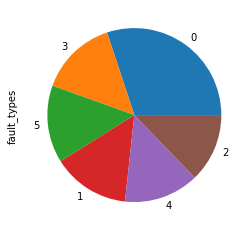

In [10]:
cldt.fault_types.value_counts().plot.pie()
plt.show()

In [11]:
X_final = np.array(X)
y_final = np.array(y)

# Train Test Split

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.15, random_state=80)

# Function for model training

In [13]:
def model_train(model, epochs, feature, label, summary):

    model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )
    if summary:
        print(model.summary())
        
    model.fit(
    feature,
    label,
    validation_split=0.2,
    batch_size=32,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )
    ]
)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def model_report(pred, label, report):
    # for classification report, use report = "classification"
    # for confusion matrix, use report = "confusion_matrix"
    p = []

    for i in range(label.shape[0]):
            p.append(np.argmax(pred[i]))

    y_truth = label.flatten().tolist()

    if report == "classification":
        print(classification_report(y_truth, p, target_names = categories))
        
    if report == "confusion_matrix":
        cm = confusion_matrix(y_truth, p)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=categories)
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
        plt.xticks(np.arange(len(categories)) + 0.5, categories)
        plt.yticks(np.arange(len(categories)) + 0.5, categories)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# Defining Parameters

In [15]:
epochs = 200
patience = 50
output_shape = 6
input_shape = X.shape[1]
X_train.shape, y_train.shape

((6681, 6), (6681,))

# Model 1 (CNN)

In [16]:
def cnn_model():
    # Input Layer
    input_layer = Input(shape = (input_shape, 1))
    
    # Convolution Layer
    X = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(input_layer)
    
    X = Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')(X)
    
    X = Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(X)
    
    X = Flatten()(X)
    # Dense Layers
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.3)(X)
    
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.2)(X)

    X = Dense(output_shape, activation = 'softmax')(X)
    
    model = Model(input_layer, X, name = 'cnn_model')
    
    return model

In [17]:
cnn = cnn_model()

2022-07-18 06:00:02.329202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 06:00:02.442311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 06:00:02.443108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 06:00:02.444276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
model_train(cnn, epochs, X_train, y_train, summary = True)

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 64)             256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 128)            24704     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             12320     
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               24704     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0 

2022-07-18 06:00:06.066497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-07-18 06:00:07.525251: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


167/167 [==============================] - 8s 4ms/step - loss: 0.8718 - accuracy: 0.6452 - val_loss: 0.4492 - val_accuracy: 0.7936
Epoch 2/200
167/167 [==============================] - 1s 3ms/step - loss: 0.4617 - accuracy: 0.7835 - val_loss: 0.3486 - val_accuracy: 0.8085
Epoch 3/200
167/167 [==============================] - 1s 3ms/step - loss: 0.3916 - accuracy: 0.8024 - val_loss: 0.4025 - val_accuracy: 0.8055
Epoch 4/200
167/167 [==============================] - 1s 4ms/step - loss: 0.3636 - accuracy: 0.8084 - val_loss: 0.3626 - val_accuracy: 0.8063
Epoch 5/200
167/167 [==============================] - 1s 4ms/step - loss: 0.3312 - accuracy: 0.8245 - val_loss: 0.3020 - val_accuracy: 0.8235
Epoch 6/200
167/167 [==============================] - 1s 3ms/step - loss: 0.3197 - accuracy: 0.8277 - val_loss: 0.2766 - val_accuracy: 0.8384
Epoch 7/200
167/167 [==============================] - 1s 3ms/step - loss: 0.3147 - accuracy: 0.8278 - val_loss: 0.2749 - val_accuracy: 0.8295
Epoch 8/200

In [19]:
pred = cnn.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00       359
          LG       0.98      1.00      0.99       175
          LL       1.00      1.00      1.00       139
         LLG       1.00      0.98      0.99       172
         LLL       0.51      0.70      0.59       164
        LLLG       0.56      0.36      0.44       171

    accuracy                           0.86      1180
   macro avg       0.84      0.84      0.83      1180
weighted avg       0.87      0.86      0.86      1180



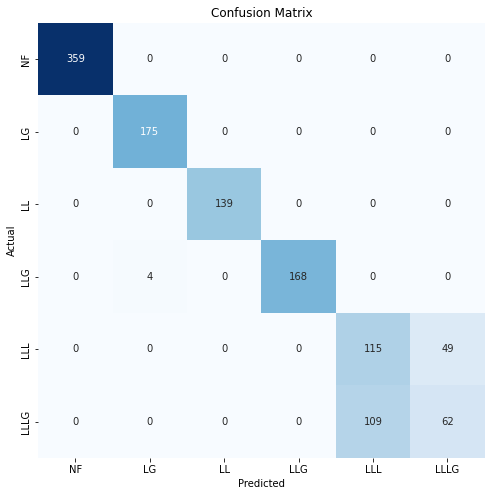

In [20]:
model_report(pred, y_test, report = "confusion_matrix")

# Model - 2 (RNN - GRU model)

In [21]:
inputs = Input(shape=(input_shape,))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = layers.GRU(2048, return_sequences=True)(expand_dims)

gru = layers.GRU(1024, return_sequences=True)(gru)

flatten = Flatten()(gru)

outputs = Dense(output_shape, activation='softmax')(flatten)


model_gru = Model(inputs=inputs, outputs=outputs)

In [22]:
model_train(model_gru, epochs, X_train, y_train, summary = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 6, 1)              0         
_________________________________________________________________
gru (GRU)                    (None, 6, 2048)           12601344  
_________________________________________________________________
gru_1 (GRU)                  (None, 6, 1024)           9443328   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 36870     
Total params: 22,081,542
Trainable params: 22,081,542
Non-trainable params: 0
_________________________________________________

In [23]:
pred = model_gru.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00       359
          LG       0.98      1.00      0.99       175
          LL       1.00      1.00      1.00       139
         LLG       1.00      0.98      0.99       172
         LLL       0.55      0.40      0.46       164
        LLLG       0.54      0.68      0.60       171

    accuracy                           0.87      1180
   macro avg       0.84      0.84      0.84      1180
weighted avg       0.87      0.87      0.86      1180



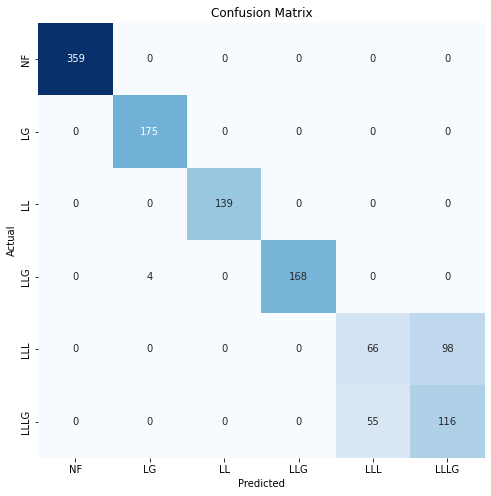

In [24]:
model_report(pred, y_test, report = "confusion_matrix")

# Using Machine Learning Classifier

# DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtf = DecisionTreeClassifier()
dtf.fit(X_train, y_train)
pred = dtf.predict(X_test)

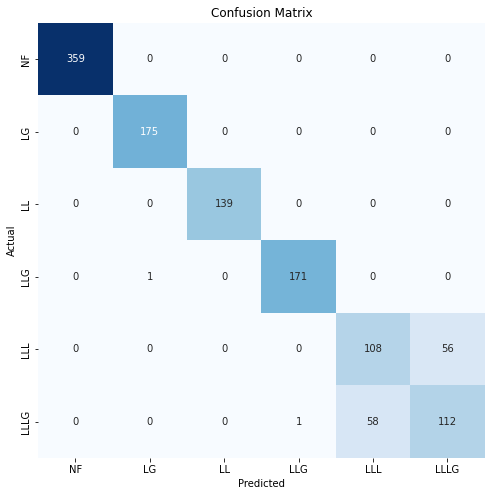

In [27]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=categories)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(len(categories)) + 0.5, categories)
plt.yticks(np.arange(len(categories)) + 0.5, categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
print(classification_report(y_test, pred, target_names = categories))

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00       359
          LG       0.99      1.00      1.00       175
          LL       1.00      1.00      1.00       139
         LLG       0.99      0.99      0.99       172
         LLL       0.65      0.66      0.65       164
        LLLG       0.67      0.65      0.66       171

    accuracy                           0.90      1180
   macro avg       0.88      0.88      0.88      1180
weighted avg       0.90      0.90      0.90      1180



# Performance Analysis on different models

In [29]:
performance1 = cnn.evaluate(X_test, y_test)
performance2 = model_gru.evaluate(X_test, y_test)
performance3 = accuracy_score(dtf.predict(X_test), y_test)

37/37 [==============================] - 0s 6ms/step - loss: 0.1884 - accuracy: 0.8669


In [30]:
print("CNN model accuracy:", performance1[1] * 100, "%")
print("GRU model accuracy", performance2[1] * 100, "%")
print("DecisionTreeClassifier model accuracy", performance3 * 100, "%")

CNN model accuracy: 86.27118468284607 %
GRU model accuracy 86.69491410255432 %
DecisionTreeClassifier model accuracy 90.16949152542372 %


# **Fault Detection**

# Data Visualization

In [31]:
ddt

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11996,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,NaN,NaN
11997,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,NaN,NaN
11998,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,NaN,NaN
11999,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,NaN,NaN


In [32]:
ddt["Output (S)"].value_counts()

0    6505
1    5496
Name: Output (S), dtype: int64

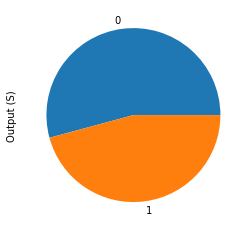

In [33]:
ddt["Output (S)"].value_counts().plot.pie()
plt.show()

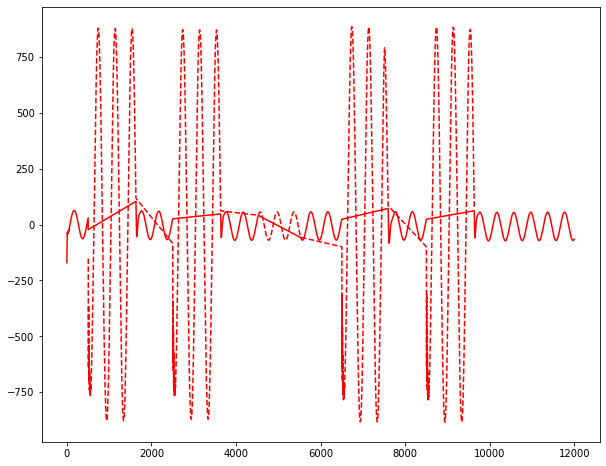

In [34]:
plt.figure(figsize = (10,8))
plt.plot(ddt[ddt['Output (S)'] == 0]["Ia"],'r')
plt.plot(ddt[ddt['Output (S)'] == 1]["Ia"],'r--')

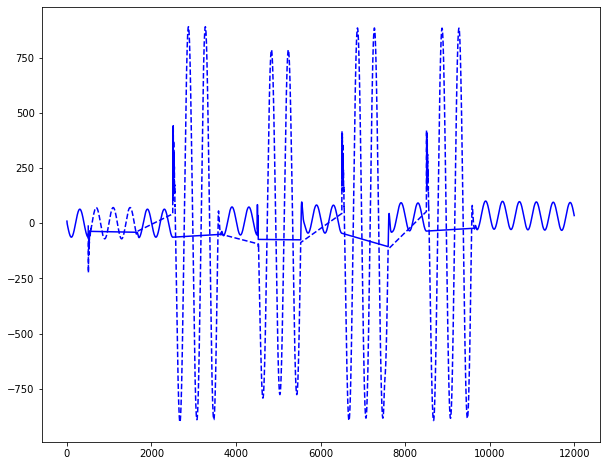

In [35]:
plt.figure(figsize = (10,8))
plt.plot(ddt[ddt['Output (S)'] == 0]["Ib"],'b')
plt.plot(ddt[ddt['Output (S)'] == 1]["Ib"],'b--')

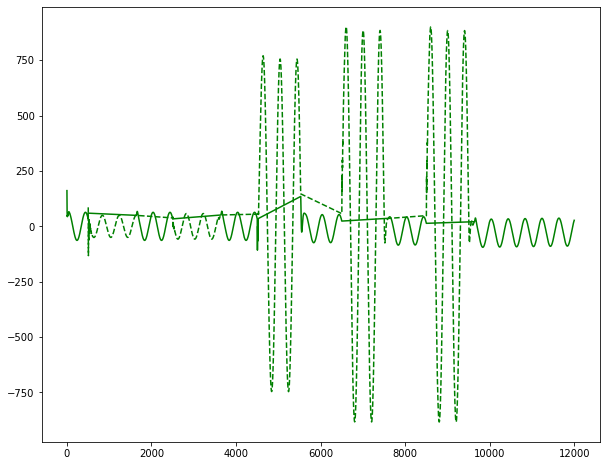

In [36]:
plt.figure(figsize = (10,8))
plt.plot(ddt[ddt['Output (S)'] == 0]["Ic"],'g')
plt.plot(ddt[ddt['Output (S)'] == 1]["Ic"],'g--')

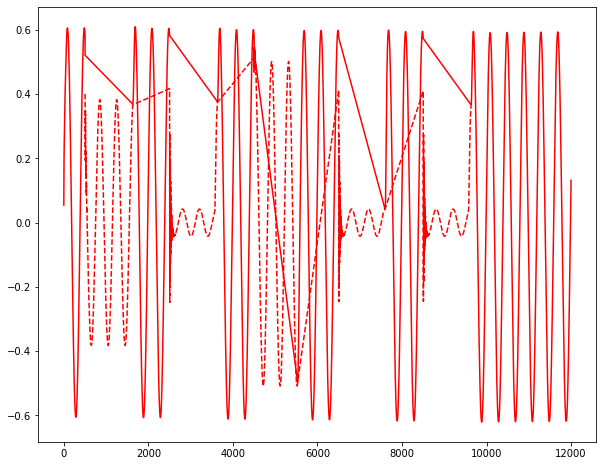

In [37]:
plt.figure(figsize = (10,8))
plt.plot(ddt[ddt['Output (S)'] == 0]["Va"],'r')
plt.plot(ddt[ddt['Output (S)'] == 1]["Va"],'r--')

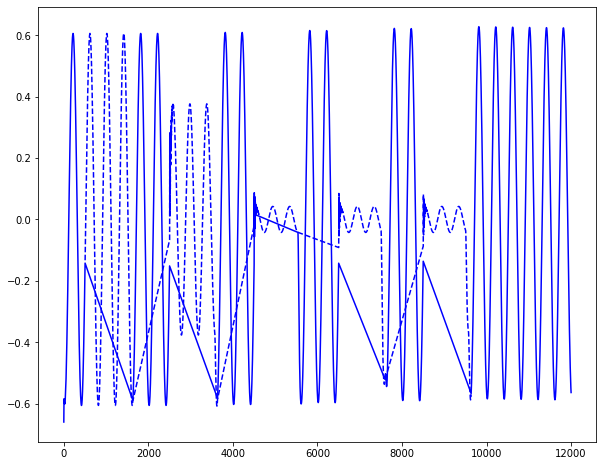

In [38]:
plt.figure(figsize = (10,8))
plt.plot(ddt[ddt['Output (S)'] == 0]["Vb"],'b')
plt.plot(ddt[ddt['Output (S)'] == 1]["Vb"],'b--')

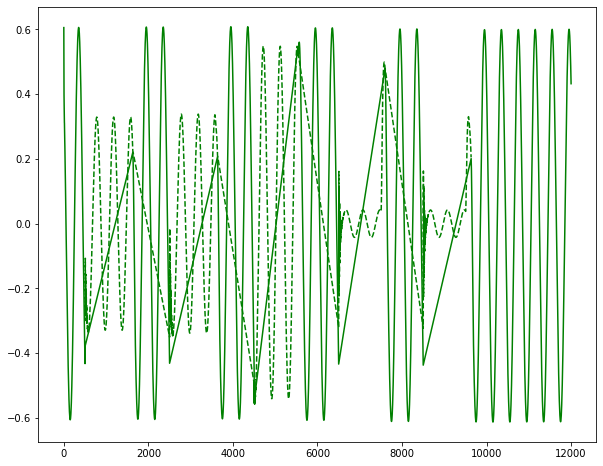

In [39]:
plt.figure(figsize = (10,8))
plt.plot(ddt[ddt['Output (S)'] == 0]["Vc"],'g')
plt.plot(ddt[ddt['Output (S)'] == 1]["Vc"],'g--')

# Feature Extraction

In [40]:
Xd = ddt.iloc[:, 1:7]
Xd = Xd / Xd.max(axis = 0)
yd = ddt.iloc[:, 0]

In [41]:
Xd

,Ia,Ib,Ic,Va,Vb,Vc
0,-0.192463,0.010361,0.178916,0.089348,-1.051039,0.995377
1,-0.138004,0.006932,0.128781,0.167251,-1.001173,0.865118
2,-0.101792,0.004286,0.095806,0.231241,-0.964009,0.763266
3,-0.090213,0.002696,0.085996,0.256242,-0.959165,0.733199
4,-0.072127,0.000664,0.070228,0.295888,-0.942069,0.675799
...,...,...,...,...,...,...
11996,-0.074783,0.043217,0.027641,0.154823,-0.879186,0.752327
11997,-0.074344,0.042102,0.028311,0.170166,-0.884230,0.742150
11998,-0.073889,0.040986,0.028966,0.185462,-0.889048,0.731787
11999,-0.073419,0.039868,0.029608,0.200707,-0.893640,0.721242


In [42]:
X_ddt = np.array(Xd)
y_ddt = np.array(yd)

# Defining Parameters

In [43]:
output_shape = 2
input_shape = Xd.shape[1]
categories = ["No Fault", "Fault"]
Xd.shape, yd.shape

((12001, 6), (12001,))

# Train Test Split

In [44]:
from sklearn.preprocessing import MinMaxScaler
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_ddt, y_ddt, test_size=0.2, random_state=80)
X_train_d.shape, y_train_d.shape

((9600, 6), (9600,))

# CNN model

In [45]:
model_train(cnn, epochs, X_train_d, y_train_d, summary = False)

Epoch 1/200
240/240 [==============================] - 1s 4ms/step - loss: 0.5933 - accuracy: 0.9194 - val_loss: 0.0176 - val_accuracy: 0.9948
Epoch 2/200
240/240 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 0.0097 - val_accuracy: 0.9964
Epoch 3/200
240/240 [==============================] - 1s 3ms/step - loss: 0.0136 - accuracy: 0.9945 - val_loss: 0.0103 - val_accuracy: 0.9953
Epoch 4/200
240/240 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9935 - val_loss: 0.0117 - val_accuracy: 0.9948
Epoch 5/200
240/240 [==============================] - 1s 3ms/step - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.0085 - val_accuracy: 0.9953
Epoch 6/200
240/240 [==============================] - 1s 3ms/step - loss: 0.0127 - accuracy: 0.9952 - val_loss: 0.0087 - val_accuracy: 0.9958
Epoch 7/200
240/240 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.0083 - val_accuracy: 0.9953

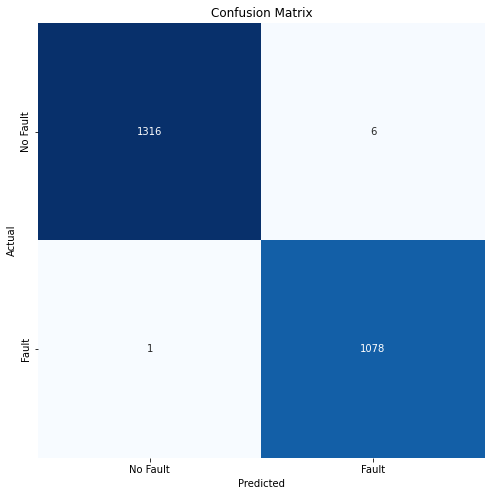

In [46]:
pred = cnn.predict(X_test_d)
model_report(pred, y_test_d, report = "confusion_matrix")

In [47]:
model_report(pred, y_test_d, report = "classification")

              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00      1322
       Fault       0.99      1.00      1.00      1079

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



# GRU Model

In [48]:
model_train(model_gru, epochs, X_train_d, y_train_d, summary = False)

Epoch 1/200
240/240 [==============================] - 5s 16ms/step - loss: 0.2462 - accuracy: 0.9639 - val_loss: 0.0115 - val_accuracy: 0.9958
Epoch 2/200
240/240 [==============================] - 3s 14ms/step - loss: 0.0157 - accuracy: 0.9937 - val_loss: 0.0175 - val_accuracy: 0.9932
Epoch 3/200
240/240 [==============================] - 3s 14ms/step - loss: 0.0181 - accuracy: 0.9932 - val_loss: 0.0114 - val_accuracy: 0.9943
Epoch 4/200
240/240 [==============================] - 3s 14ms/step - loss: 0.0122 - accuracy: 0.9953 - val_loss: 0.0104 - val_accuracy: 0.9953
Epoch 5/200
240/240 [==============================] - 3s 13ms/step - loss: 0.0136 - accuracy: 0.9943 - val_loss: 0.0081 - val_accuracy: 0.9958
Epoch 6/200
240/240 [==============================] - 3s 13ms/step - loss: 0.0165 - accuracy: 0.9940 - val_loss: 0.0203 - val_accuracy: 0.9927
Epoch 7/200
240/240 [==============================] - 3s 13ms/step - loss: 0.0153 - accuracy: 0.9943 - val_loss: 0.0185 - val_accuracy:

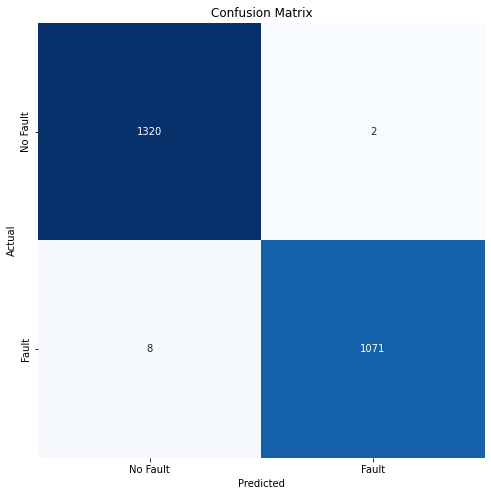

In [49]:
pred = model_gru.predict(X_test_d)
model_report(pred, y_test_d, report = "confusion_matrix")

In [50]:
model_report(pred, y_test_d, report = "classification")

              precision    recall  f1-score   support

    No Fault       0.99      1.00      1.00      1322
       Fault       1.00      0.99      1.00      1079

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



# DecisionTreeClassifier

In [57]:
dtf = DecisionTreeClassifier()
dtf.fit(X_train_d, y_train_d)
pred = dtf.predict(X_test_d)

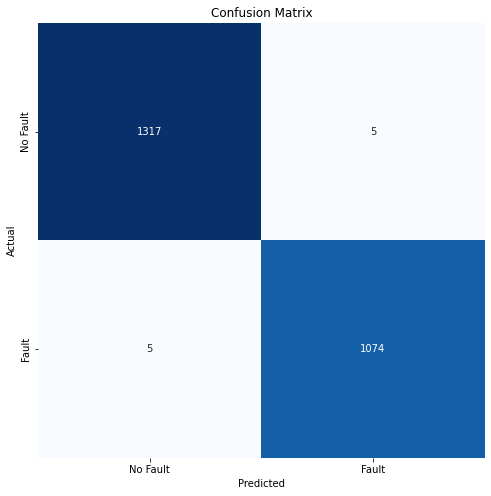

In [58]:
cm = confusion_matrix(y_test_d, pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=categories)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(len(categories)) + 0.5, categories)
plt.yticks(np.arange(len(categories)) + 0.5, categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [60]:
print(classification_report(y_test_d, pred, target_names = categories))

              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00      1322
       Fault       1.00      1.00      1.00      1079

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



# Performance Analysis of models

In [61]:
performance1 = cnn.evaluate(X_test_d, y_test_d)
performance2 = model_gru.evaluate(X_test_d, y_test_d)
performance3 = accuracy_score(dtf.predict(X_test_d), y_test_d)

76/76 [==============================] - 1s 6ms/step - loss: 0.0081 - accuracy: 0.9958


In [62]:
print("CNN model accuracy:", performance1[1] * 100, "%")
print("GRU model accuracy", performance2[1] * 100, "%")
print("DecisionTreeClassifier model accuracy", performance3 * 100, "%")

CNN model accuracy: 99.70845580101013 %
GRU model accuracy 99.58350658416748 %
DecisionTreeClassifier model accuracy 99.58350687213661 %
